In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read train and test set
train = pd.read_csv("./train.csv")
test_final = pd.read_csv("./test.csv")
del test_final["Id"]
# Get labels
labels = train["y"]
del train["y"]
del train["Id"]

# Create train and test set
X_train, X_test, y_train, y_test = train_test_split(train, labels, train_size=0.7, shuffle=False)

In [3]:
# Define Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data.values, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y        

In [4]:
# Create Datasets
train_dataset = CustomDataset(X_train, y_train)
# Why need to manip y_test but y_train works directly???
y_test = y_test.values.reshape(-1, 1)
test_dataset = CustomDataset(X_test, y_test)

In [5]:
# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [17]:
# Define model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.fc = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 1)])
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.relu(self.fc(x))
        for layer in self.layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x


input_size = train_dataloader.dataset.data.shape[1]
num_layers = 10
hidden_size = 80
model = SimpleNN(input_size, hidden_size, num_layers)


In [18]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [19]:
# train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    epoch_loss = 0.0
    num_batches = len(dataloader)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        epoch_loss += loss.item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_batch_loss = epoch_loss / num_batches
    return avg_batch_loss

# test_loop
def test_loop(dataloader, model, loss_fn, optimizer):
    epoch_test_loss = 0.0
    num_batches = len(dataloader)
    model.eval()
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            epoch_test_loss += loss_fn(pred, y).item()

    avg_batch_test_loss = epoch_test_loss / num_batches
    return avg_batch_test_loss



In [20]:
epochs = 500
train_loss_list = []
test_loss_list = []
for t in range(epochs):
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    train_loss_list.append(train_loss)
    test_loss = test_loop(test_dataloader, model, loss_fn, optimizer)
    test_loss_list.append(test_loss)
    if t % 20 == 0:
        print("-------- epoch", t, "---------------")
        print(f"train loss {train_loss}")
        print(f"test loss {test_loss}")

-------- epoch 0 ---------------
train loss 88821.61654829545
test loss 42967.995553523935
-------- epoch 20 ---------------
train loss 199.6098064769398
test loss 250.82970282372008
-------- epoch 40 ---------------
train loss 89.31247485767712
test loss 135.04128216682597
-------- epoch 60 ---------------
train loss 48.47328709689054
test loss 87.74746355097345
-------- epoch 80 ---------------
train loss 38.30918038108132
test loss 81.31232241366772
-------- epoch 100 ---------------
train loss 21.61605237614025
test loss 53.95870435998795
-------- epoch 120 ---------------
train loss 22.967326511036266
test loss 51.47130649647814
-------- epoch 140 ---------------
train loss 13.13933331749656
test loss 32.709326520879216
-------- epoch 160 ---------------
train loss 9.448943970420144
test loss 26.75949421334774
-------- epoch 180 ---------------
train loss 22.344590503519232
test loss 32.96218320156665
-------- epoch 200 ---------------
train loss 6.171830998767506
test loss 19.746

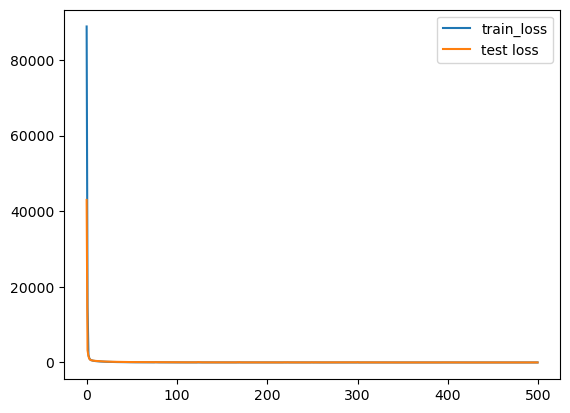

In [21]:
plt.figure()
plt.plot(range(epochs), train_loss_list, label="train_loss")
plt.plot(range(epochs), test_loss_list, label="test loss")
plt.legend()
plt.show()

In [11]:
y_final_pred = model(torch.tensor(test_final.values, dtype=torch.float32))

In [12]:
pred = model(test_dataloader.dataset.data).detach().numpy().reshape(-1)
label = test_dataloader.dataset.labels.detach().numpy().reshape(-1)

dict = {"predictions": pred,
        "labels": label}

In [13]:
dict

{'predictions': array([-221.99146 , -251.79382 , -313.62717 , ...,   62.781097,
        -202.07132 , -291.6684  ], dtype=float32),
 'labels': array([-219.08011 , -251.87553 , -315.46127 , ...,   61.176537,
        -202.13649 , -289.219   ], dtype=float32)}

In [14]:
df = pd.DataFrame(dict)
df.to_csv("./pred.csv")